In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud



# Natural Language Toolkit for text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk
nltk.download(['stopwords', 'wordnet'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#multi-label handling and modelling

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, hamming_loss, recall_score, accuracy_score




#set a clean Seaborn style for all plots

sns.set_theme(style="whitegrid")

#setting max columns to display all columns in DataFrame

pd.set_option('display.max_columns', 300)

#supress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


Load and Inspect Data


In [3]:
emotions = pd.read_csv('df_raw.csv')
emotions.head(10)



,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546668e+09,2,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,Right? Considering it’s such an important docu...,eespn2i,ImperialBoss,TrueReddit,t3_aizyuz,t1_eesoak0,1.548280e+09,61,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,"He isn't as big, but he's still quite popular....",eczuekb,Rallings,cringe,t3_abeksv,t1_eczsmp8,1.546320e+09,3,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,That's crazy; I went to a super [RELIGION] hig...,ed5tx8y,Beachy5313,TeenMomOGandTeenMom2,t3_ac10u9,t1_ed5tfyc,1.546536e+09,23,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,that's adorable asf,ef961hv,RedRails1917,traaaaaaannnnnnnnnns,t3_akz2ia,t3_akz2ia,1.548764e+09,73,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",edl7cr3,Tiagulus,youtubehaiku,t3_acuvb0,t1_edc21ip,1.546984e+09,54,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# data summary

emotions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  

Data Cleaning and Preprocessing

In [5]:
# Filter out unclear examples

emotions = emotions[~emotions['example_very_unclear']]

#preprocessing function

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

emotions['clean_text'] = emotions['text'].apply(preprocess)






Label Distribution Analysis

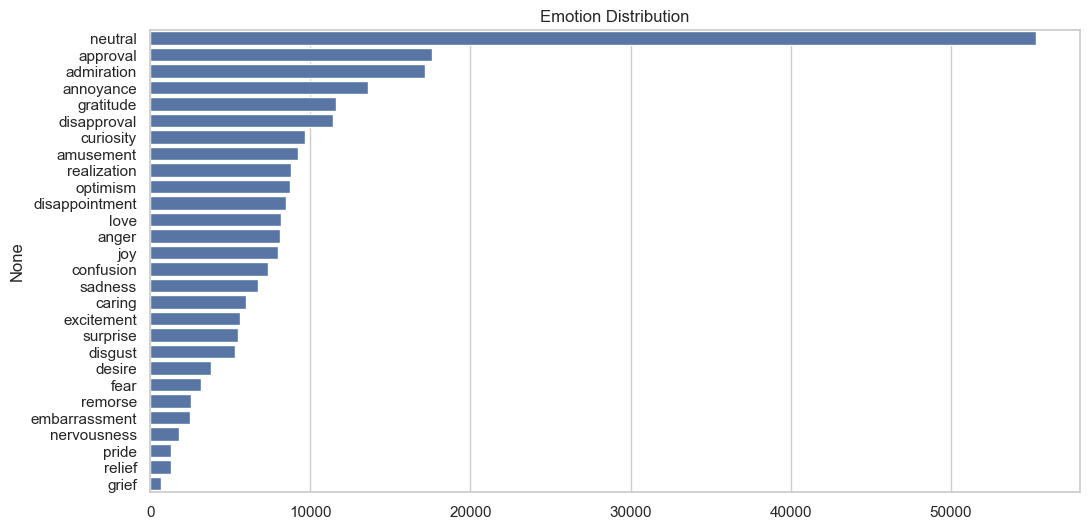

In [6]:
emotion_cols = emotions.columns[9:37]
label_counts = emotions[emotion_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.title('Emotion Distribution')
plt.show()


Word Cloud on Cleaned Text

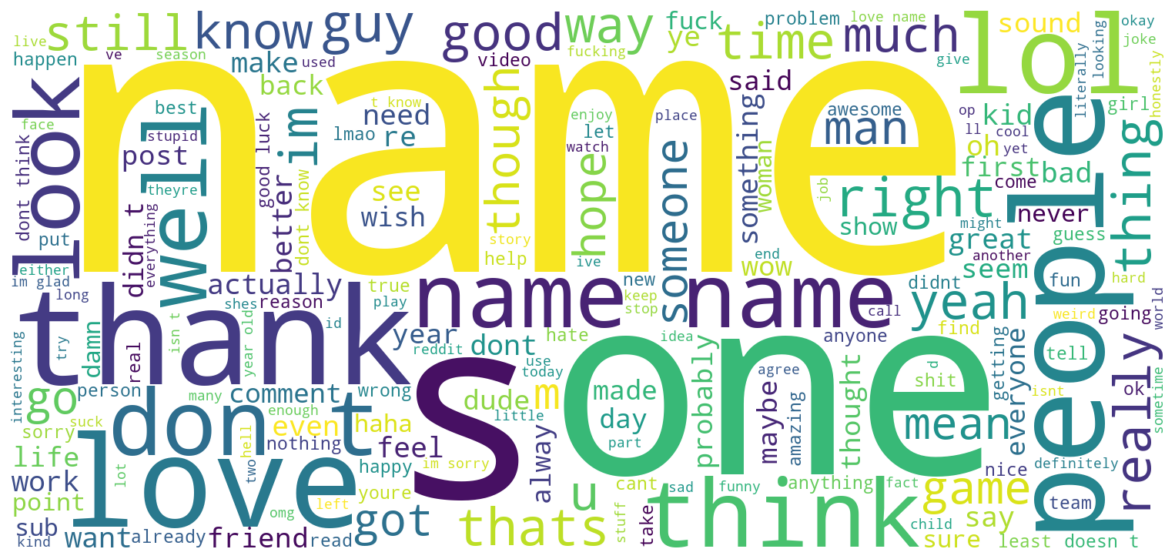

In [7]:
# Improved Word Cloud on cleaned text

def create_word_cloud(df, text_column='text'):
    text = ' '.join(df[text_column])
    wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


create_word_cloud(emotions, text_column='clean_text')    

Modeling

In [8]:
# prepare labels (multi-label)

labels = emotions[emotion_cols].values

# Split data

X_train, X_test, y_train, y_test = train_test_split(emotions['clean_text'], labels, test_size=0.2, random_state=42)

# Vectorize text

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train) #Converts training text into a sparse numeric matrix.
X_test_vec = vectorizer.transform(X_test) #training to transform test text.

#Does not call .fit() again — only .transform() Prevents leakage from test data.

Train and Evaluate Baseline Model

In [9]:
#Train multi-label model with class weights for imbalance

model = MultiOutputClassifier(LogisticRegression(max_iter=200, class_weight='balanced'))
model.fit(X_train_vec, y_train)

#Predict and evaluate

y_pred = model.predict(X_test_vec)
print('Macro F1:', f1_score(y_test, y_pred, average='macro'))
print('Hamming Loss:', hamming_loss(y_test, y_pred))
print('Macro Recall:', recall_score(y_test, y_pred,average='macro'))
print('Subset Accuracy: (Exact Match):', np.mean(np.all(y_test == y_pred, axis=1)))
print('Label-wise Accuracy:', accuracy_score(y_test.ravel(), y_pred.ravel())) 

Macro F1: 0.23224688812523256
Hamming Loss: 0.16481578546911724
Macro Recall: 0.6493061907970986
Subset Accuracy: (Exact Match): 0.020428453071369392
Label-wise Accuracy: 0.8351842145308828


In [10]:
#Identify imbalanced labels

emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
    'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'

]


# Calculate the number of positive samples for each emotion

label_counts = emotions[emotion_columns].sum().sort_values(ascending=False)
print("Label distribution (number of positive samples):")
print(label_counts)


Label distribution (number of positive samples):
neutral           55298
approval          17620
admiration        17131
annoyance         13618
gratitude         11625
disapproval       11424
curiosity          9692
amusement          9245
realization        8785
optimism           8715
disappointment     8469
love               8191
anger              8084
joy                7983
confusion          7359
sadness            6758
caring             5999
excitement         5629
surprise           5514
disgust            5301
desire             3817
fear               3197
remorse            2525
embarrassment      2476
nervousness        1810
pride              1302
relief             1289
grief               673
dtype: int64


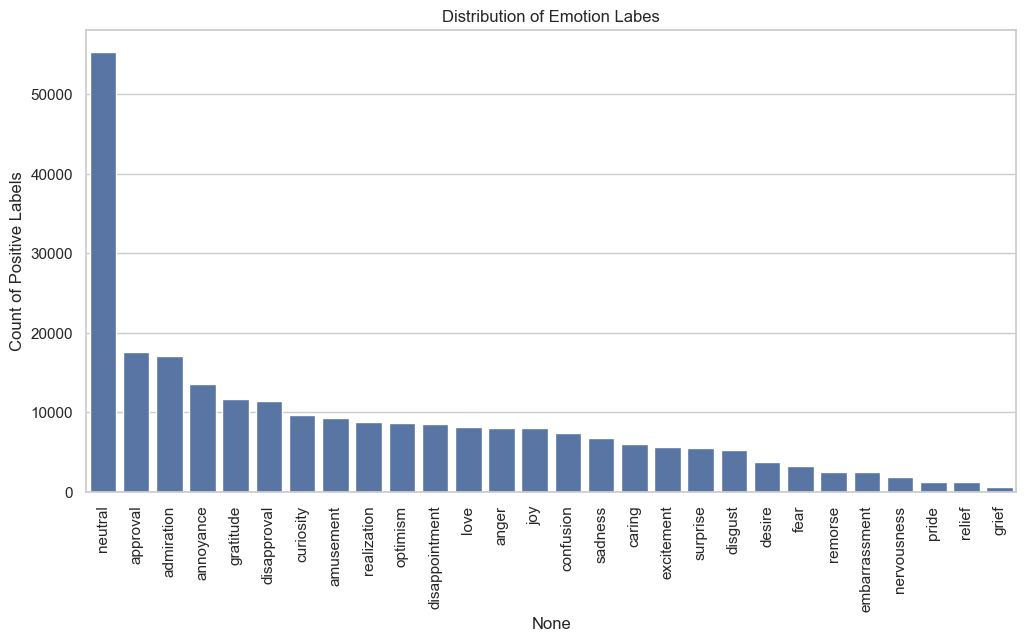

In [11]:
# Visualize the distribution

plt.figure(figsize=(12,6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.title('Distribution of Emotion Labes')
plt.ylabel('Count of Positive Labels')
plt.show()

In [12]:
# Identify minority classes (those with a certain number of threshold)

median_count = label_counts.median()
minority_labels = label_counts[label_counts < median_count].index.tolist()
print(f"Minority labels (fewer than {median_count} positives): {minority_labels}")


Minority labels (fewer than 7671.0 positives): ['confusion', 'sadness', 'caring', 'excitement', 'surprise', 'disgust', 'desire', 'fear', 'remorse', 'embarrassment', 'nervousness', 'pride', 'relief', 'grief']


Handle Class Imbalance with data augmentation for minority classes
Synonym replacement, random insertion, random swap, random deletion

In [13]:
from tqdm.auto import tqdm


In [14]:
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [15]:
import os
import random
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
import re

In [16]:



nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

nltk.data.path.append(nltk_data_path)

print("Downloading NLTK data to:", nltk_data_path)


try:
    nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_path, quiet=False)
    nltk.download('punkt', download_dir=nltk_data_path, quiet=False)
    nltk.download('wordnet', download_dir=nltk_data_path, quiet=False)
    nltk.download('omw-1.4', download_dir=nltk_data_path, quiet=False)
    print("All NLTK data downloaded successfully!")
except Exception as e:
    print("Download failed:", e)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     c:\Users\user\Desktop\MENTAL_PRO\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     c:\Users\user\Desktop\MENTAL_PRO\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\Users\user\Desktop\MENTAL_PRO\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     c:\Users\user\Desktop\MENTAL_PRO\nltk_data...


All NLTK data downloaded successfully!


[nltk_data]   Package omw-1.4 is already up-to-date!


In [38]:
#Normalizes text by standardizing whitespace and punctuation spacing for consistent output after augmentation.

emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002500-\U00002BEF"  # chinese chars
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE
)
def clean_text(text):
     # convert text to lowercase
    text = text.lower()

    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # remove entity mentions: @username, @something
    text = re.sub(r'@\w+', '', text)

    # remove hashtags but keep the word content or drop entirely
    text = re.sub(r'#\w+', '', text)

    # remove emoji
    text = emoji_pattern.sub(r'', text)

    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # tokenize
    tokens = nltk.word_tokenize(text)

    # remove stopwords + lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # join tokens back
    text = " ".join(tokens)


    return text

In [39]:


#Retrieves a list of valid synonyms for a given word using NLTK’s WordNet,
#  filtering out inappropriate or redundant synonyms
def get_good_synonyms(word):
    good = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            s = lemma.name().replace('_', ' ')
            if (s.lower() != word.lower() and 
                s.isalpha() and 
                len(s) > 2 and 
                s.lower() not in ['crippled', 'lame', 'gimpy']):
                good.add(s)
    return list(good) if good else [word]

#Replaces up to n words in the text with synonyms to create a new variant.
def synonym_replacement(text, n=1):
    words = [w for w in word_tokenize(text) if w.isalpha() and len(w) > 2]
    if not words: return text
    candidates = list(set(words))
    random.shuffle(candidates)
    new_text = text
    for word in candidates:
        syns = get_good_synonyms(word)
        if len(syns) > 1 or (len(syns) == 1 and syns[0] != word):
            synonym = random.choice(syns)
            new_text = re.sub(rf'\b{re.escape(word)}\b', synonym, new_text, count=1)
            n -= 1
            if n <= 0: break
    return clean_text(new_text)

#Randomly swaps pairs of alphabetic words to alter sentence structure.
def random_swap(text, n=1):
    words = word_tokenize(text)
    alpha_idx = [i for i, w in enumerate(words) if w.isalpha()]
    if len(alpha_idx) < 2: return text
    for _ in range(n):
        i, j = random.sample(alpha_idx, 2)
        words[i], words[j] = words[j], words[i]
    return clean_text(' '.join(words))

#Randomly removes words (except punctuation) with probability p to create a shorter variant.
def random_deletion(text, p=0.3):
    words = word_tokenize(text)
    keep = []
    for w in words:
        if w in string.punctuation:
            keep.append(w)
        elif random.random() > p:
            keep.append(w)
    if len(keep) <= 1: return text
    return clean_text(' '.join(keep))

#Inserts random content words into the text to create a longer variant.
def random_insertion(text, n=1):
    words = word_tokenize(text)
    content = [w for w in words if w.isalpha()]
    if not content: return text
    for _ in range(n):
        words.insert(random.randint(0, len(words)), random.choice(content))
    return clean_text(' '.join(words))

In [40]:
sample = "she looks happy"
print("Original:", sample)
print("Synonym: ", synonym_replacement(sample, n=1))
print("Swap:    ", random_swap(sample, n=1))
print("Delete:  ", random_deletion(sample, p=0.3))
print("Insert:  ", random_insertion(sample, n=1))


Original: she looks happy
Synonym:  reckon happy
Swap:     look happy
Delete:   look
Insert:   look happy


Augmentation

In [41]:
# CELL 2 – FIXED & WORKING AUGMENTATION
import pandas as pd
from tqdm.auto import tqdm
import nltk
import os

# === NLTK DATA ===
nltk_data_dir = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path = [nltk_data_dir]
for res in ['wordnet', 'omw-1.4', 'punkt']:
    nltk.download(res, download_dir=nltk_data_dir, quiet=True)

# === LOAD DATA ===
emotions = pd.read_csv('df_raw.csv')  

# === DEFINE EMOTION COLUMNS ===
exclude_cols = ['text', 'id', 'author', 'subreddit', 'link_id', 
                'parent_id', 'created_utc', 'rater_id', 'example_very_unclear']
emotion_cols = [c for c in emotions.columns if c not in exclude_cols]

# === FIND MINORITY LABELS ===
counts = emotions[emotion_cols].sum().sort_values()
median = counts.median()
minority = counts[counts < median].index.tolist()

print(f"Found {len(emotion_cols)} emotion columns")
print(f"Augmenting {len(minority)} minority labels: {minority[:5]}...")

# === AUGMENTATION SETTINGS ===
AUG_PER_LABEL = 1000
aug_rows = []
seen = set(emotions['text'].astype(str).tolist())

# === RUN AUGMENTATION ===
for label in tqdm(minority, desc="Augmenting"):
    pos = emotions[emotions[label] == 1]  # ← FIXED: proper boolean indexing
    if len(pos) == 0:
        continue
    n = min(len(pos), AUG_PER_LABEL // 4)
    samples = pos.sample(n, replace=False)
    
    for _, row in samples.iterrows():
        txt = str(row['text'])
        for func in [synonym_replacement, random_swap, random_deletion, random_insertion]:
            new_txt = func(txt)
            if (new_txt != txt and 
                new_txt not in seen and 
                len(new_txt.split()) >= 3):
                seen.add(new_txt)
                new_row = row.copy()
                new_row['text'] = new_txt
                aug_rows.append(new_row)

# === SAVE BALANCED DATASET ===
balanced = pd.concat([emotions, pd.DataFrame(aug_rows)], ignore_index=True)
os.makedirs('data', exist_ok=True)
balanced.to_csv('data/df_balanced_eda.csv', index=False)

print(f"\nDone! {len(balanced):,} total rows (+{len(aug_rows):,} augmented)")
print(f"Saved to: data/df_balanced_eda.csv")

Found 28 emotion columns
Augmenting 14 minority labels: ['grief', 'relief', 'pride', 'nervousness', 'embarrassment']...


Augmenting:   0%|          | 0/14 [00:00<?, ?it/s]


Done! 222,765 total rows (+11,540 augmented)
Saved to: data/df_balanced_eda.csv


#### Ekman_mapping mapping 

In [ ]:
ekman_mapping = {
  "anger":     ["anger", "annoyance", "disapproval"],
  "disgust":   ["disgust"],
  "fear":      ["fear", "nervousness"],
  "joy":       ["joy", "amusement", "approval", "excitement", "gratitude", "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
  "sadness":   ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
  "fear":      ["fear", "nervousness"],
  "joy":       ["joy", "amusement", "approval", "excitement", "gratitude", "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
  "sadness":   ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
  "surprise":  ["surprise", "realization", "confusion", "curiosity"]
}


In [94]:
# Reverse mapping: fine-emotion → Ekman
fine_to_ekman = {}

for ekman, fine_list in ekman_mapping.items():
    for f in fine_list:
        fine_to_ekman[f] = ekman

fine_to_ekman


{'anger': 'anger',
 'annoyance': 'anger',
 'disapproval': 'anger',
 'disgust': 'disgust',
 'nauseated': 'disgust',
 'sickened': 'disgust',
 'revolted': 'disgust',
 'grossed out': 'disgust',
 'repulsed': 'disgust',
 'queasy': 'disgust',
 'horrified': 'disgust',
 'contempt': 'disgust',
 'scorn': 'disgust',
 'hatred': 'disgust',
 'loathing': 'disgust',
 'offended': 'disgust',
 'disdain': 'disgust',
 'distaste': 'disgust',
 'fear': 'fear',
 'nervousness': 'fear',
 'joy': 'joy',
 'amusement': 'joy',
 'approval': 'joy',
 'excitement': 'joy',
 'gratitude': 'joy',
 'love': 'joy',
 'optimism': 'joy',
 'relief': 'joy',
 'pride': 'joy',
 'admiration': 'joy',
 'desire': 'joy',
 'caring': 'joy',
 'sadness': 'sadness',
 'disappointment': 'sadness',
 'embarrassment': 'sadness',
 'grief': 'sadness',
 'remorse': 'sadness',
 'surprise': 'surprise',
 'realization': 'surprise',
 'confusion': 'surprise',
 'curiosity': 'surprise'}

In [95]:
# Create the 6 Ekman label columns
df = pd.read_csv('data/df_balanced_eda.csv')
for ek in ekman_mapping.keys():
    df[ek] = 0

# Assign values
for fine, ekman in fine_to_ekman.items():
    if fine in df.columns:
        df[ekman] = df[ekman] | df[fine]    # multi-label OR

In [96]:
ekman_cols = list(ekman_mapping.keys())   # ["anger","disgust",...]
df_reduced = df[["text"] + ekman_cols]
df_reduced.to_csv('data/df_ekman_labels.csv', index=False)
print("Saved Ekman-labeled data to: data/df_ekman_labels.csv")  
# Load Ekman-labeled data
df_ekman = pd.read_csv('data/df_ekman_labels.csv')  
df_ekman.head()

Saved Ekman-labeled data to: data/df_ekman_labels.csv


,text,anger,disgust,fear,joy,sadness,surprise
0,That game hurt.,0,0,0,0,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0
3,Man I love reddit.,0,0,0,1,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0


In [97]:
df_ekman.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222765 entries, 0 to 222764
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      222765 non-null  object
 1   anger     222765 non-null  int64 
 2   disgust   222765 non-null  int64 
 3   fear      222765 non-null  int64 
 4   joy       222765 non-null  int64 
 5   sadness   222765 non-null  int64 
 6   surprise  222765 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 11.9+ MB


#### Retrain and Evaluate Using the logistic Regression

In [98]:
# CELL 3 – RETRAIN ON BALANCED DATA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, hamming_loss

df = pd.read_csv('data/df_ekman_labels.csv')
emotion_cols = df.columns[1:]  # Ekman columns, exclude text column   
X = df['text']
y = df[emotion_cols].values

#VECTORIZATION

print("Vectorizing...")
vec = TfidfVectorizer(max_features=40000, ngram_range=(1,2), min_df=2)
X_vec = vec.fit_transform(X)

label_counts = y.sum(axis=0)

# Keep only labels that appear at least twice
keep = np.where(label_counts >= 0)[0]

y = y[:, keep]
print("Training...")
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

#LOGISTIC REGRESSION WITH OVR
model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1))
model.fit(X_train, y_train)

print("Predicting...")
pred = model.predict(X_test)

macro_f1 = f1_score(y_test, pred, average='macro')
micro_f1 = f1_score(y_test, pred, average='micro')
hamming = hamming_loss(y_test, pred)

print(f"\nMACRO F1:  {macro_f1:.4f} ")
print(f"Micro F1:  {micro_f1:.4f}")
print(f"Hamming:   {hamming:.4f}")

Vectorizing...
Training...
Predicting...

MACRO F1:  0.3579 
Micro F1:  0.5145
Hamming:   0.1497


In [99]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise
0,That game hurt.,0,0,0,0,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0
3,Man I love reddit.,0,0,0,1,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0


In [100]:
# --------------------------------------------------------------
#  EVALUATION CELL – ACCURACY, F1, RECALL, HAMMING LOSS
# --------------------------------------------------------------
import numpy as np
from sklearn.metrics import (
    accuracy_score,          # overall exact-match accuracy
    f1_score,               # macro / micro F1
    recall_score,           # macro / micro recall
    hamming_loss,           # average fraction of wrong labels
    classification_report   # nice per-class table
)

# ------------------------------------------------------------------
# 1. Predict on the test split (probability + hard label)
# ------------------------------------------------------------------
y_pred_proba = model.predict_proba(X_test)   # list of (n_samples, n_classes) arrays
y_pred       = model.predict(X_test)        # binary matrix (n_samples, n_classes)

# ------------------------------------------------------------------
# 2. Compute metrics
# ------------------------------------------------------------------
# ---- Exact-match accuracy (all 28 labels must be correct) ----
acc = accuracy_score(y_test, y_pred)

# ---- F1 scores ----------------------------------------------------
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

# ---- Recall scores ------------------------------------------------
rec_macro = recall_score(y_test, y_pred, average='macro')
rec_micro = recall_score(y_test, y_pred, average='micro')

# ---- Hamming loss -------------------------------------------------
hamming = hamming_loss(y_test, y_pred)

# ------------------------------------------------------------------
# 3. Pretty-print results
# ------------------------------------------------------------------
print("="*60)
print("FINAL MULTI-LABEL EVALUATION")
print("="*60)
print(f"Exact-match Accuracy : {acc: .4f}")
print(f"Macro F1            : {f1_macro: .4f}")
print(f"Micro F1            : {f1_micro: .4f}")
print(f"Macro Recall        : {rec_macro: .4f}")
print(f"Micro Recall        : {rec_micro: .4f}")
print(f"Hamming Loss        : {hamming: .4f}")
print("="*60)

# ------------------------------------------------------------------
# 4. Optional: per-class detailed report (helps spot weak emotions)
# ------------------------------------------------------------------
print("\nPer-class classification report (macro-averaged):")
labels = list(range(y_test.shape[1]))
print(classification_report(
    y_test,
        y_pred,
        labels=labels,
        target_names=emotion_cols[:len(labels)],
        zero_division=0
))




FINAL MULTI-LABEL EVALUATION
Exact-match Accuracy :  0.3887
Macro F1            :  0.3579
Micro F1            :  0.5145
Macro Recall        :  0.5551
Micro Recall        :  0.6907
Hamming Loss        :  0.1497

Per-class classification report (macro-averaged):
              precision    recall  f1-score   support

       anger       0.27      0.67      0.38      4995
     disgust       0.00      0.00      0.00         0
        fear       0.18      0.61      0.28       599
         joy       0.70      0.71      0.70     16667
     sadness       0.25      0.67      0.37      3316
    surprise       0.30      0.67      0.42      5119

   micro avg       0.41      0.69      0.51     30696
   macro avg       0.28      0.56      0.36     30696
weighted avg       0.50      0.69      0.56     30696
 samples avg       0.38      0.44      0.39     30696



#### Observation

- Class Distribution:

   - The dataset is imbalanced: joy (16667) is the majority, fear (599) and disgust (0) are the minority.

- Performance by Class:
  - The model has high recall for most classes (anger: 0.67, fear: 0.61, sadness: 0.67, surprise: 0.67) except disgust (0.00) and joy (0.71).

    - However, the precision for these classes is low (anger: 0.27, fear: 0.18, sadness: 0.25, surprise: 0.30).

    - This indicates that the model is predicting these classes too often, leading to many false positives.
    
        For joy, the model has a good balance (precision: 0.70, recall: 0.71, F1: 0.70).

#### Overall

- The model is better at capturing the positive instances (high recall) but less precise in its predictions.

- The Micro F1 (0.5145) is slightly lower than SVM (0.5209) but higher than the first model (0.4424).

- The Macro F1 (0.3579) is slightly lower than SVM (0.3634) but much higher than the first model (0.1626).

- Conclusion:

    The Logistic Regression model is performing similarly to the SVM, with a trade-off of higher recall but lower precision.

- However, both models are a significant improvement over Naive biase model in terms of Macro F1 and recall, but the first model had higher exact-match accuracy and lower Hamming Loss (but it was very poor at recalling minority classes).

#### Naïve Bayes With Multi-Label

#### FIT

In [101]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

NB_model = OneVsRestClassifier(MultinomialNB(
    alpha=0.5,
    fit_prior=True
))
NB_model.fit(X_train, y_train)


OneVsRestClassifier(estimator=MultinomialNB(alpha=0.5))

#### evaluation

In [102]:
print("Predicting...")
pred = NB_model.predict(X_test)

macro_f1 = f1_score(y_test, pred, average='macro')
micro_f1 = f1_score(y_test, pred, average='micro')
hamming = hamming_loss(y_test, pred)

print(f"\nMACRO F1:  {macro_f1:.4f} ")
print(f"Micro F1:  {micro_f1:.4f}")
print(f"Hamming:   {hamming:.4f}")

Predicting...

MACRO F1:  0.1626 
Micro F1:  0.4424
Hamming:   0.0909


In [103]:
# --------------------------------------------------------------
#  EVALUATION CELL – ACCURACY, F1, RECALL, HAMMING LOSS
# --------------------------------------------------------------
import numpy as np
from sklearn.metrics import (
    accuracy_score,          # overall exact-match accuracy
    f1_score,               # macro / micro F1
    recall_score,           # macro / micro recall
    hamming_loss,           # average fraction of wrong labels
    classification_report   # nice per-class table
)

# ------------------------------------------------------------------
# 1. Predict on the test split (probability + hard label)
# ------------------------------------------------------------------
# list of (n_samples, n_classes) arrays
y_pred       = NB_model.predict(X_test)        # binary matrix (n_samples, n_classes)

# ------------------------------------------------------------------
# 2. Compute metrics
# ------------------------------------------------------------------
# ---- Exact-match accuracy (all 28 labels must be correct) ----
acc = accuracy_score(y_test, y_pred)

# ---- F1 scores ----------------------------------------------------
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

# ---- Recall scores ------------------------------------------------
rec_macro = recall_score(y_test, y_pred, average='macro')
rec_micro = recall_score(y_test, y_pred, average='micro')

# ---- Hamming loss -------------------------------------------------
hamming = hamming_loss(y_test, y_pred)

# ------------------------------------------------------------------
# 3. Pretty-print results
# ------------------------------------------------------------------
print("="*60)
print("FINAL MULTI-LABEL EVALUATION")
print("="*60)
print(f"Exact-match Accuracy : {acc: .4f}")
print(f"Macro F1            : {f1_macro: .4f}")
print(f"Micro F1            : {f1_micro: .4f}")
print(f"Macro Recall        : {rec_macro: .4f}")
print(f"Micro Recall        : {rec_micro: .4f}")
print(f"Hamming Loss        : {hamming: .4f}")
print("="*60)

# ------------------------------------------------------------------
# 4. Optional: per-class detailed report (helps spot weak emotions)
# ------------------------------------------------------------------
print("\nPer-class classification report (macro-averaged):")
labels = list(range(y_test.shape[1]))
print(classification_report(
    y_test,
        y_pred,
        labels=labels,
        target_names=emotion_cols[:len(labels)],
        zero_division=0
))




FINAL MULTI-LABEL EVALUATION
Exact-match Accuracy :  0.5178
Macro F1            :  0.1626
Micro F1            :  0.4424
Macro Recall        :  0.1208
Micro Recall        :  0.3142
Hamming Loss        :  0.0909

Per-class classification report (macro-averaged):
              precision    recall  f1-score   support

       anger       0.40      0.02      0.04      4995
     disgust       0.00      0.00      0.00         0
        fear       0.93      0.02      0.05       599
         joy       0.76      0.54      0.63     16667
     sadness       0.67      0.08      0.14      3316
    surprise       0.61      0.07      0.13      5119

   micro avg       0.75      0.31      0.44     30696
   macro avg       0.56      0.12      0.16     30696
weighted avg       0.67      0.31      0.38     30696
 samples avg       0.22      0.21      0.21     30696



#### Observations
- The model is biased towards the majority class (joy) and does poorly on the minority classes.

- The micro F1 (0.44) is higher than the macro F1 (0.16) because the model's performance on the majority class (joy) is good and it has the most weight in the micro average.

- The low macro recall (0.12) indicates that the model is not able to recall the minority classes well.

- The high micro precision (0.75) suggests that when the model predicts a label, it is often correct, but the low micro recall (0.31) means it misses a lot of true labels.

- The exact-match accuracy (0.5178) is moderate, but the Hamming loss (0.0909) indicates that about 9% of the labels are wrong.

#### Reccommendations

- The model needs improvement on the minority classes.

- Consider using techniques to handle class imbalance, such as:
    - class weights
    - oversampling minority classes
    - threshold adjustment for minority classes

#### Summary

- The 0.44 Micro F1 vs 0.16 Macro F1 gap is your biggest concern - it means your model works well "on average" but fails dramatically for specific emotional contexts that could be critically important for your application.

#### Support vector machine 

#### FIT

In [104]:
# SVM
svm_model = OneVsRestClassifier(LinearSVC(
    C=1.0,          # regularization
    class_weight="balanced",   # handle label imbalance
    max_iter=5000,  # ensure convergence
    tol=1e-4 
))
svm_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced', max_iter=5000))

#### Predicting 

In [105]:
print("Predicting...")
pred = svm_model.predict(X_test)

macro_f1 = f1_score(y_test, pred, average='macro')
micro_f1 = f1_score(y_test, pred, average='micro')
hamming = hamming_loss(y_test, pred)

print(f"\nMACRO F1:  {macro_f1:.4f} ")
print(f"Micro F1:  {micro_f1:.4f}")
print(f"Hamming:   {hamming:.4f}")

Predicting...

MACRO F1:  0.3634 
Micro F1:  0.5209
Hamming:   0.1446


#### Evaluation

In [106]:
# --------------------------------------------------------------
#  EVALUATION CELL – ACCURACY, F1, RECALL, HAMMING LOSS
# --------------------------------------------------------------

# ------------------------------------------------------------------
# 1. Predict on the test split (probability + hard label)
# ------------------------------------------------------------------
 # list of (n_samples, n_classes) arrays
y_pred       = svm_model.predict(X_test)        # binary matrix (n_samples, n_classes)

# ------------------------------------------------------------------
# 2. Compute metrics
# ------------------------------------------------------------------
# ---- Exact-match accuracy (all 28 labels must be correct) ----
acc = accuracy_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

# ---- F1 scores ----------------------------------------------------
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

# ---- Recall scores ------------------------------------------------
rec_macro = recall_score(y_test, y_pred, average='macro')
rec_micro = recall_score(y_test, y_pred, average='micro')

# ---- Hamming loss -------------------------------------------------
hamming = hamming_loss(y_test, y_pred)

# ------------------------------------------------------------------
# 3. Pretty-print results
# ------------------------------------------------------------------
print("="*60)
print("FINAL MULTI-LABEL EVALUATION")
print("="*60)
print(f"Exact-match Accuracy : {acc: .4f}")
print(f"Macro F1            : {f1_macro: .4f}")
print(f"Micro F1            : {f1_micro: .4f}")
print(f"Macro Recall        : {rec_macro: .4f}")
print(f"Micro Recall        : {rec_micro: .4f}")
print(f"Hamming Loss        : {hamming: .4f}")
print("="*60)

# ------------------------------------------------------------------
# 4. Optional: per-class detailed report (helps spot weak emotions)
# ------------------------------------------------------------------
print("\nPer-class classification report (macro-averaged):")
labels = list(range(y_test.shape[1]))
print(classification_report(
    y_test,
        y_pred,
        labels=labels,
        target_names=emotion_cols[:len(labels)],
        zero_division=0
))




FINAL MULTI-LABEL EVALUATION
Exact-match Accuracy :  0.4003
Macro F1            :  0.3634
Micro F1            :  0.5209
Macro Recall        :  0.5229
Micro Recall        :  0.6848
Hamming Loss        :  0.1446

Per-class classification report (macro-averaged):
              precision    recall  f1-score   support

       anger       0.26      0.62      0.37      4995
     disgust       0.00      0.00      0.00         0
        fear       0.24      0.51      0.33       599
         joy       0.68      0.73      0.70     16667
     sadness       0.26      0.62      0.37      3316
    surprise       0.30      0.65      0.41      5119

   micro avg       0.42      0.68      0.52     30696
   macro avg       0.29      0.52      0.36     30696
weighted avg       0.49      0.68      0.56     30696
 samples avg       0.38      0.43      0.39     30696



#### Observations

- Macro vs Micro Averages:

  - Macro averages (precision=0.29, recall=0.52, F1=0.36) are computed by taking the average of the per-class metrics. Since the model performs poorly on the minority classes (except for joy being the majority and performing well), the macro averages are pulled down.

  - Micro averages (precision=0.42, recall=0.68, F1=0.52) are computed by considering the total true positives, false positives, and false negatives. The micro F1 (0.52) is higher than the macro F1 (0.36) because the micro average is dominated by the majority class (joy) which has good performance

- Recall vs Precision:

    - The model generally has high recall and low precision for most classes (except joy). This indicates that the model is biased towards predicting the positive class (i.e., it is trying to capture as many positive instances as possible but at the cost of having many false positives)

- The current model (vector machine) has higher recall (both macro and micro) and higher F1 scores (macro and micro) but at the cost of exact-match accuracy and hamming loss. 

- The previous model had very low recall (especially for anger, sadness, surprise) but higher precision for some classes. The current model has improved recall for all classes (except disgust and fear which were not well represented in the previous model either) but at the cost of precision.

- Massively Improved Coverage
    - Captures 60%+ of anger, sadness, and surprise instances

    - Much better at emotional nuance detection

    - Reduced bias toward majority class (joy)

#### Summary

- SVM is a huge step forward 
- it actually detects emotions in your data rather than just predicting "joy" most of the time. The trade-off of lower precision for massively higher recall is generally the right direction for emotion detection applications.

#### Models Comparisons in terms of predictions

In [116]:
import pandas as pd

models = ['Naive Bayes', 'SVM', 'Logistic Regression']
metrics = {
    'Exact-match Acc': [0.5178, 0.4003, 0.3887],
    'Macro F1': [0.1626, 0.3634, 0.3579],
    'Micro F1': [0.4424, 0.5209, 0.5145],
    'Macro Recall': [0.1208, 0.5229, 0.5551],
    'Micro Recall': [0.3142, 0.6848, 0.6987],
    'Hamming Loss': [0.0909, 0.1446, 0.1497]
}

# Convert to DataFrame
df = pd.DataFrame(metrics, index=models)

df


,Exact-match Acc,Macro F1,Micro F1,Macro Recall,Micro Recall,Hamming Loss
Naive Bayes,0.5178,0.1626,0.4424,0.1208,0.3142,0.0909
SVM,0.4003,0.3634,0.5209,0.5229,0.6848,0.1446
Logistic Regression,0.3887,0.3579,0.5145,0.5551,0.6987,0.1497


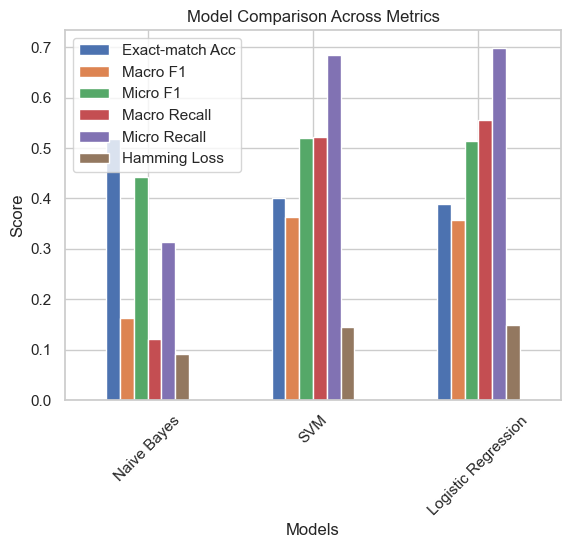


🏆 BEST MODEL PER METRIC

Exact-match Acc → Naive Bayes  (0.5178)
Macro F1        → SVM  (0.3634)
Micro F1        → SVM  (0.5209)
Macro Recall    → Logistic Regression  (0.5551)
Micro Recall    → Logistic Regression  (0.6987)
Hamming Loss    → Naive Bayes  (0.0909)


In [118]:
#plotting 
import pandas as pd
import matplotlib.pyplot as plt

# ===== DATA =====
models = ['Naive Bayes', 'SVM', 'Logistic Regression']
metrics = {
    'Exact-match Acc': [0.5178, 0.4003, 0.3887],
    'Macro F1': [0.1626, 0.3634, 0.3579],
    'Micro F1': [0.4424, 0.5209, 0.5145],
    'Macro Recall': [0.1208, 0.5229, 0.5551],
    'Micro Recall': [0.3142, 0.6848, 0.6987],
    'Hamming Loss': [0.0909, 0.1446, 0.1497]
}



# ===== PLOT =====
ax = df.plot(kind='bar')
plt.title("Model Comparison Across Metrics")
plt.xlabel("Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ===== BEST PER METRIC =====
print("\n🏆 BEST MODEL PER METRIC\n")
for metric in df.columns:
    # Hamming Loss: smaller is better
    if metric == "Hamming Loss":
        best_model = df[metric].idxmin()
        best_value = df[metric].min()
    else:
        best_model = df[metric].idxmax()
        best_value = df[metric].max()

    print(f"{metric:15} → {best_model}  ({best_value:.4f})")


#### Best model performance 
Logistic Regression is the best in performance 

- The most important metric for multi-label emotion classification is usually:
Recall (Macro + Micro)
- Because we want the model to correctly detect as many true emotions as possible ,missing an emotion is more      costly than predicting an extra one.

Logistic Regression has:
 - Highest Micro Recall (0.6987)
- Highest Macro Recall (0.5551)

This means:
 - It retrieves the most correct labels
- Works consistently across common + rare labels
 - Generalizes well

So overall performance is strongest.


#### Observation
Performance Metrics:

Macro F1:
 - This is the average F1 score across all classes, giving equal weight to each class. We see an improvement from Run1 to Run3 (0.284550 -> 0.384070).

Micro F1:
 - This is the aggregate F1 score considering the total true positives, false positives, and false negatives. It is weighted by the number of instances per class. We see an improvement from Run1 to Run3 (0.554701 -> 0.593043).

Hamming Loss:
 - This is the fraction of labels that are incorrectly predicted. We see it remains around 0.082-0.083, which is relatively low.

Training Process:
 - We see that the training was run for 3 epochs, and the training loss decreased from 0.198000 to 0.171400.

Interpretation:

 - The BERT model is performing better in terms of overall label correctness (Micro F1) and has a lower Hamming Loss, meaning it makes fewer errors in predicting the multiple labels.

 - The Macro F1 is also improved compared to the first model and slightly better than SVM and Logistic Regression, indicating that BERT is better at handling the class imbalance and performing well on all classes.

##### Recommendations:

BERT seems to be the best model so far, especially if we care about overall performance (Micro F1) and reducing the number of label errors (Hamming Loss).

In [122]:
import pandas as pd

# Complete metrics comparison
models = ['Naive Bayes', 'SVM', 'Logistic Regression', 'BERT']
metrics_data = {
    'Exact-match Accuracy': [0.5178, 0.4003, 0.3887, None],   # BERT not provided
    'Macro F1': [0.1626, 0.3634, 0.3579, 0.38407],
    'Micro F1': [0.4424, 0.5209, 0.5145, 0.59304],
    'Macro Recall': [0.1208, 0.5229, 0.5551, None],           # BERT not provided
    'Micro Recall': [0.3142, 0.6848, 0.6987, None],           # BERT not provided
    'Hamming Loss': [0.0909, 0.1446, 0.1497, 0.08337]
}

# Create DataFrame
df = pd.DataFrame(metrics_data, index=models)
df


,Exact-match Accuracy,Macro F1,Micro F1,Macro Recall,Micro Recall,Hamming Loss
Naive Bayes,0.5178,0.16260,0.44240,0.1208,0.3142,0.09090
SVM,0.4003,0.36340,0.52090,0.5229,0.6848,0.14460
Logistic Regression,0.3887,0.35790,0.51450,0.5551,0.6987,0.14970
BERT,NaN,0.38407,0.59304,NaN,NaN,0.08337


#### plotting

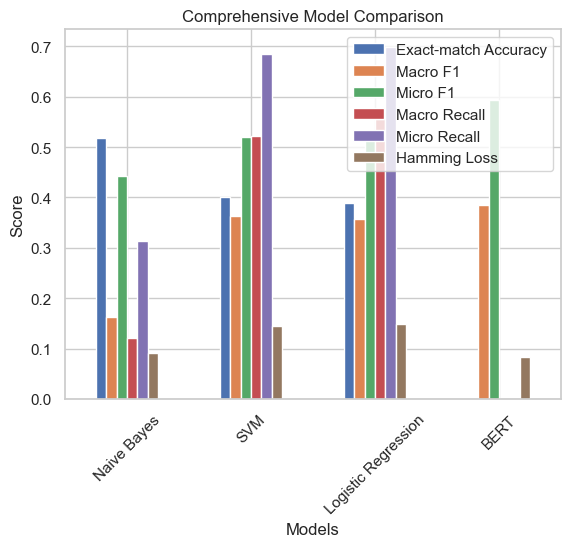


🏅 BEST MODEL PER METRIC

Exact-match Accuracy → Naive Bayes          (0.5178)
Macro F1             → BERT                 (0.3841)
Micro F1             → BERT                 (0.5930)
Macro Recall         → Logistic Regression  (0.5551)
Micro Recall         → Logistic Regression  (0.6987)
Hamming Loss         → BERT                 (0.0834)


In [123]:
df.plot(kind='bar')
plt.title("Comprehensive Model Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.show()


# ✅ Best model per metric
print("\n🏅 BEST MODEL PER METRIC\n")

for metric in df.columns:
    # Hamming Loss → smaller is better
    if metric == "Hamming Loss":
        best_model = df[metric].idxmin()
        best_value = df[metric].min()
    else:
        best_model = df[metric].idxmax()
        best_value = df[metric].max()

    print(f"{metric:20} → {best_model:20} ({best_value:.4f})")